<img src="../images/basic_bubble.png" width=350 alt="Colormesh plot of a simple warm bubble within our model after 20 seconds of model run time"></img>

# Crash Course Towards Your First Model

---

## Overview

The following notebook serves as a crash course in constructing a simple two-dimensional mesoscale atmospheric numerical model. To begin, we select a closed set of dynamical equations, in line with Klemp and Wilhelmson (1978; hereafter KW78). Necessary assumptions are stated to simplify the equations into a managble form to maximize both computational and educational applications. Pre-defined model configurations are presented (in an attempt) to ensure numerical stability. Equations are converted into finite-differences and then broken down into Python code to explicity demonstrate the construction of a numerical model. Additional resources will be provided in the future regarding varying model configurations and utilizing increasingly more realistic and complex model equations.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [NumPy Basics](https://foundations.projectpythia.org/core/numpy/numpy-basics.html) | Necessary | |
| [Introduction to xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Helpful | Familiarity with coordinate-aware arrays |
| Dynamical Meteorology | Helpful | |

- **Time to learn**: Estimated 30 to 60 minutes.

---

## Imports

Here we'll be using a basic set of Python libraries, along with Numba for fast numerical routines. A helpful constants file is also imported, along side the code that controls the running of the model. (For those curious, these files can be viewed [here](./constants) and [here](./constants).)

In [7]:
import numpy as np
import numba
import xarray as xr
import matplotlib.pyplot as plt

from constants import *
from driver import ModelDriver
from model_visulization import ModelVis

ModuleNotFoundError: No module named 'panel'

## Basic Equations

### Starting Equations (from WK78)

#### Diagnostics
    
DEQ 1. Equation of State (2.1) 
$$
p = \rho R_{d} T
$$ 
* $p$: Pressure
* $\rho$: Density
* $R_{d}$: Specific gas constant for dry air
* $T: Temperature
<br>

DEQ 2. Exner Function (2.2)
$$
\Pi = (\frac{p}{p_{0}})^\frac{R_{d}}{c_{p}}
$$
* $\Pi$: Non-Dimensional Pressure
* $p$: Pressure
* $p_{0}$: Reference Pressure
* $R_{d}$: Specific gas constant for dry air
* $c_{p}$: Specific heat at constant pressure    
<br>


#### Prognostics
    
PEQ 1-2. Momentum Equation (Zonal & Vertical; 2.4)
$$
\underset{1}{\frac{du_{i}}{dt}}+ 
\underset{2}{c_{p} \overline{\theta_{v}} \frac{\partial \pi}{\partial x_{i}} }=
\underset{3}{\delta_{i_{3}}} 
\underset{4}{g}\left[
\underset{5}{\frac{\theta}{\overline{\theta}} - 1}+
\underset{6}{0.61(q_{v}-\overline{q_{v}})}-
\underset{7}{q_{c}-q_{r}}\right]-
\underset{8}{\epsilon_{ij_{3}}}fu_{i}+ 
\underset{9}{D_{u_i}}
$$

1. Lagrangian of Wind
2. PGF Term
3. Kronecker Delta (i.e., the term that follows only appears form dimension 3, the vertical)
4. Gravity
5. Dry Buoyancy Contribution
6. Moist Buoyancy Contribution
7. Water Loading
8. Coriolis Term
9. Turblence Term

<i>Derived via Navier-Stokes equations, along with DEQ1-2, Hydrostatic Function, and Linearized Pressure Term. Tensor Notation is used for simplicity.</i>
<br> 
 
PEQ 3. Prognostic Equations (2.5)
$$
\underset{1}{\frac{d\phi}{dt}}=
\underset{2}{M_{\phi}}+ 
\underset{3}{D_{\phi}}
$$

1. Lagrangian of Prognositc Variable
2. Microphysical Term 
3. Turbulence Term
        
<i>$\phi$ is representative of either $\theta, q_{v}, q_{r},$ or  $q_{c}$</i>
<br>
    
PEQ 4. Pressure Equation (2.7a)
$$
\underset{1}{\frac{\partial\pi}{\partial t}}+
\underset{2}{\frac{ \overline{c}^2}{c_{p}{\overline\rho\overline{\theta_{v}^2}}}
{\frac{\partial}{\partial x_{j}}(\overline{\rho}\overline{\theta_{v}}} u_{j})}=
\underset{3}{f_{\pi}}
$$

1. Eularian of Pressure
2. Pressure Adjustment Term
3. Non-Relevant Terms for Sound & Gravity Waves (<i>See KW78 2.7b</i>)

<i>Derived using Compressible Continuity & Thermodynamic Equations; Tensor Notation Used for Simplicity</i>

### Assumptions and Simplification

In this notebook we construct a two-dimensional, dry, and compressible atmospheric model that is broadly in line with KW78, though several assumptions and choice configurations were made to simplify the current model for computational and educational efficency.
<br>
1. We will only consider the zonal ($x$) and vertical ($z$) components.
2. Base-state variables are a function of $z$ only, denoted by $\overline{\phi}$.
3. Water-vapor is neglected (i.e, $q_{v}, q_{r}, q_{c} = 0$), so  $T_{v} = T$ and/or $\theta_{v} = \theta$.
4. Coriolis force, microphysics, and Turbulence are also neglected(i.e., $f, M_{\theta}, D_{\theta} = 0$).     
5. As in KW78, the $f_{\pi}$ term in Pressure Equation (PEQ4-3) is neglected due to its negligible influences on convective-scale processes along with sound and gravity waves.
6. Sub-Grid Processes require parameterizations in order to achieve model closure. For example, sub-grid turbulence is first obtained using Reynolds Averaged prognostic variables (i.e., breaking up variables into mean and turbulence components), and then must be parameterized using additional assumptions (such as the flux-gradient approach). 
7. The current test case is designed to have a calm and isentropic base-state (i.e., $\frac{\partial \overline\theta}{\partial t}$ and  $\overline{U} = 0$)

### Final Prognostic Equations

The afformentioned assumptions allowed for the derivation of the following simplified equations that serve as the foundation for the numerical model.
<br> 

EQ1. Zonal Momentum Equation
$$
\underset{1}{\frac{du}{dt}}+
\underset{2}{c_{p} \bar{\theta} \frac{\partial \pi}{\partial x}}
=0
$$

1. Lagrangian Derivative of Zonal Wind
2. PGF Term
<br>

EQ2. Vertical Momentum Equation
$$
\underset{1}{\frac{dw}{dt}}+
\underset{2}{c_{p} \bar{\theta} \frac{\partial \pi}{\partial z}}= 
\underset{3}{g\left[\frac{\theta}{\bar{\theta}} - 1\right]}
$$

1. Lagrangian Derivative of Vertical Wind
2. PGF Term
3. Dry Buoyancy Contribution
<br>

EQ3. Prognostic Equations
$$
\underset{1}{\frac{d\theta}{dt}}
=0
$$

1. Lagrangian Derivative of Potential Temperature
<br>

EQ4. Pressure Equation 
$$
\underset{1}{\frac{\partial\pi}{\partial t}}+ 
\underset{2}{\frac{\overline{c}^2}{c_{p}\overline{\rho}\overline{\theta}^2}[
\frac{\partial}{\partial x}(\overline{\rho}\overline{\theta}u) +
\frac{\partial}{\partial z}(\overline{\rho}\overline{\theta}w)]} 
=0
$$

1. Eularian Derivative of Pressure
2. Pressure Adjustment Terms

## Model Configuration

Summary: 
- The current test case was configured using a 32 x 20 $km^2$ grid, including by 160 zonal grid points (nx) and 100 vertical grid points (nz), with both the horizontal and vertical grid-spacing ($\Delta x, \Delta z$) set to 200 m. Equations are integrated using a 0.1 s time-step ($\Delta t$).  
<br>

Domain (32 km x 20 km):
- nx = 160
- nz = 100
- $dx, dz = 200 m$
<br>

Grid Type (Staggered Grid: C) (In/Around Box-Good for Advection)
- Mass: Centered (i,k)
- Velocity: Edges 
    - u (i +/- 1/2, k)
    - w (i, k +/- 1/2)
<br>

<img src="../images/c-grid_example.svg" width=500 alt="Visualization of the staggered offsets of a C grid. u momentum points exist to the left and right of the mass points, and w momentum points to the top and bottom."></img>

<br>


Boundary Conditions
- Free-Slip Lower
- Rigid Top 
- Periodic Lateral 
<br>

Initial Conditions
- P_surf = 950 hPa, with remainder of atmosphere determined via hydrostatic-balance
- Theta = 300 K (isentropic)
- Calm (u, w) = 0
- CI: +3 K Warm Bubble $\theta^{\prime}$, with radius of 4 $km$ centered at $z = 2$ $km$. $p^{\prime}$ (and thus $\pi$) is adjusted accordingly.
<br>


## Discritization

### General Approach

The following space/time discritization methods were used to convert the model equations into a code-ready format.

Centered Spatial Differencing, on a C-grid:
$$
\frac{\partial \phi}{\partial x_i} \approx \frac{\phi_{i+\frac{1}{2}} - \phi_{i-\frac{1}{2}}}{\Delta x_i}
$$  

However, due to averaging, many of the formulations became equivalent to centered differencing on a non-staggered grid:

$$
\frac{\partial \phi}{\partial x_i} \approx \frac{\phi_{i+1} - \phi_{i-1}}{2 \Delta x_i}
$$ 

Leap-Frog Time Differencing:
$$
\frac{\partial \phi}{\partial t} \approx \frac{\phi^{\tau+1} - \phi^{\tau-1}}{2 \Delta t}
$$

### Equation-by-Equation

#### u-momentum

Given our indexing notation, this equation is centered on the $(i + \frac{1}{2}, k)$ point.

u advection Term:
$$
u\frac{\partial u}{\partial x} \cong
\frac{1}{2\Delta x}u_{i + \frac{1}{2}, k}(u_{i + \frac{3}{2}, k}-
u_{i - \frac{1}{2}, k})
$$

TODO: show full derivation, not just final equation

To implement this in code, we must consider that the array indexes are whole numbers, and relative to the particular array. When we loop over the two spatial dimensions for $u$, this becomes:

In [8]:
@numba.njit()
def u_tendency_u_advection_term(u, dx):
    term = np.zeros_like(u)
    for k in range(1, u.shape[0] - 1):
        for i in range(1, u.shape[1] - 1):
            term[k, i] = u[k, i] * (u[k, i + 1] - u[k, i - 1]) / (2 * dx)
    return term

w advection term:

$$
w\frac{\partial u}{\partial z} \cong
\frac{1}{4}( w_{i + 1, k + \frac{1}{2}} + w_{i + 1, k - \frac{1}{2}} +
w_{i, k + \frac{1}{2}} + w_{i, k - \frac{1}{2}})
\frac{1}{2\Delta z}(u_{i + \frac{1}{2}, k + 1} - u_{i + \frac{1}{2}, k - 1} )
$$

TODO: show full derivation, not just final equation

In [9]:
@numba.njit()
def u_tendency_w_advection_term(u, w, dz):
    term = np.zeros_like(u)
    for k in range(1, u.shape[0] - 1):
        for i in range(1, u.shape[1] - 1):
            term[k, i] = 0.25 * (
                w[k + 1, i] + w[k + 1, i - 1] + w[k, i] + w[k, i - 1] 
            ) * (u[k + 1, i] - u[k - 1, i]) / (2 * dz)
    return term

PGF Term:

$$
c_{p}\bar{\theta} \frac{\partial \pi}{\partial x} \cong 
c_{p}\bar{\theta_{k}}\frac{1}{\Delta x}(\pi_{i+1,k}-\pi_{i,k} )
$$

In [10]:
@numba.njit()
def u_tendency_pgf_term(u, pi, theta_base, dx):
    term = np.zeros_like(u)
    for k in range(1, u.shape[0] - 1):
        for i in range(1, u.shape[1] - 1):
            term[k, i] = c_p * theta_base[k] * (pi[k, i] - pi[k, i - 1]) / dx
    return term

Now, we can combine all these RHS terms, accounting for the negation/subtraction present in the full equation

In [11]:
@numba.njit()
def u_tendency(u, w, pi, theta_base, dx, dz):
    return (
        u_tendency_u_advection_term(u, dx)
        + u_tendency_w_advection_term(u, w, dz)
        + u_tendency_pgf_term(u, pi, theta_base, dx)
    ) * -1

#### w momentum

Here, we proceed similarly

u advection term:

$$
u\frac{\partial w}{\partial x} = 
\frac{1}{4}(u_{i + \frac{1}{2}, k + 1} +
u_{i + \frac{1}{2}, k} + 
u_{i - \frac{1}{2}, k +1} +
u_{i - \frac{1}{2}, k})
\frac{1}{2\Delta x}(w_{i + 1, k + \frac{1}{2}} - 
w_{i - 1, k + \frac{1}{2}})
$$

TODO: full derivation

In [12]:
@numba.njit()
def w_tendency_u_advection_term(u, w, dx):
    term = np.zeros_like(w)
    for k in range(2, term.shape[0] - 2):
        for i in range(1, term.shape[1] - 1):
            term[k, i] = 0.25 * (
                u[k, i] + u[k, i + 1] + u[k - 1, i] + u[k - 1, i + 1]  
            ) * (w[k, i + 1] - w[k, i - 1]) / (2 * dx)
    return term

w advection term:

$$
w\frac{\partial w}{\partial z}=
w_{i, k + \frac{1}{2}}
\frac{1}{2\Delta z} (w_{i, k + \frac{3}{2}} - w_{i-1, \frac{1}{2}})
$$

TODO: full derivation

In [13]:
@numba.njit()
def w_tendency_w_advection_term(w, dz):
    term = np.zeros_like(w)
    for k in range(2, term.shape[0] - 2):
        for i in range(1, term.shape[1] - 1):
            term[k, i] = w[k, i] * (w[k + 1, i] - w[k - 1, i]) / (2 * dz)
    return term

PGF term:

$$ 
c_{p}\overline{\theta}\frac{\partial \pi}{\partial z} =
c_{p} \frac{1}{2}( \overline{\theta}_{k+1} + \overline{\theta}_{k})
\frac{1}{\Delta z}(\pi_{i, k+1} - \pi_{i,k})
$$

TODO: full derivation

In [14]:
@numba.njit()
def w_tendency_pgf_term(w, pi, theta_base, dz):
    term = np.zeros_like(w)
    for k in range(2, term.shape[0] - 2):
        for i in range(1, term.shape[1] - 1):
            term[k, i] = c_p * 0.5 * (theta_base[k] + theta_base[k - 1]) * (pi[k - 1, i] - pi[k, i]) / dz
    return term

Buoyancy Term:

$$
  g\left[\frac{\theta^{\prime}}{\overline{\theta}}\right] =
  g\left[\frac{\theta_{i, k+1}^{\prime} + \theta_{i, k}^{\prime}}{\overline{\theta}_{k+1}, \overline{\theta}_{k}}\right]
$$

TODO: full derivation

In [15]:
@numba.njit()
def w_tendency_buoyancy_term(w, theta_p, theta_base):
    term = np.zeros_like(w)
    for k in range(2, term.shape[0] - 2):
        for i in range(1, term.shape[1] - 1):
            term[k, i] = gravity * (theta_p[k, i] + theta_p[k - 1, i]) / (theta_base[k] + theta_base[k - 1]) 
    return term

Which, in combination, becomes:

In [16]:
@numba.njit()
def w_tendency(u, w, pi, theta_p, theta_base, dx, dz):
    return (
        w_tendency_u_advection_term(u, w, dx) * -1.0
        - w_tendency_w_advection_term(w, dz)
        - w_tendency_pgf_term(w, pi, theta_base, dz)
        + w_tendency_buoyancy_term(w, theta_p, theta_base)
    )

#### Theta tendency equation

u advection term:

$$
       u\frac{\partial \theta^{\prime}}{\partial x} = 
       \frac{1}{2}(u_{i+\frac{1}{2}, k} + u_{i-\frac{1}{2}})
       \frac{1}{2\Delta x}(\theta_{i+1,k}^{\prime}-\theta_{i-1,k}^{\prime})
     $$

In [17]:
@numba.njit()
def theta_p_tendency_u_advection_term(u, theta_p, dx):
    term = np.zeros_like(theta_p)
    for k in range(1, theta_p.shape[0] - 1):
        for i in range(1, theta_p.shape[1] - 1):
            term[k, i] = (
                (u[k, i + 1] + u[k, i]) / 2
                * (theta_p[k, i + 1] - theta_p[k, i - 1]) / (2 * dx)
            )
    return term

w advection of theta perturbation:

$$
       w\frac{\partial \theta^{\prime}}{\partial z} = 
       \frac{1}{2}(w_{i+\frac{1}{2}, k} + w_{i-\frac{1}{2}})
       \frac{1}{2\Delta z}(\theta_{i,k+1}^{\prime}-\theta_{i,k-1}^{\prime})
     $$

In [18]:
@numba.njit()
def theta_p_tendency_w_advection_of_perturbation_term(w, theta_p, dz):
    term = np.zeros_like(theta_p)
    for k in range(1, theta_p.shape[0] - 1):
        for i in range(1, theta_p.shape[1] - 1):
            term[k, i] = (
                (w[k + 1, i] + w[k, i]) / 2
                * (theta_p[k + 1, i] - theta_p[k - 1, i]) / (2 * dz)
            )
    return term

w advection of theta base state:

$$
   w\frac{\partial \overline{\theta}}{\partial z} = 
   \frac{1}{2}(w_{i, k+\frac{1}{2}} + w_{i,k\frac{1}{2}})
   \frac{1}{2\Delta z}(\overline{\theta}_{k+1}-\overline\theta_{k-1})
 $$

In [19]:
@numba.njit()
def theta_p_tendency_w_advection_of_base_term(w, theta_p, theta_base, dz):
    term = np.zeros_like(theta_p)
    for k in range(1, theta_p.shape[0] - 1):
        for i in range(1, theta_p.shape[1] - 1):
            term[k, i] = (
                (w[k + 1, i] + w[k, i]) / 2
                * (theta_base[k + 1] - theta_base[k - 1]) / (2 * dz)
            )
    return term

Combining, becomes:

In [20]:
@numba.njit()
def theta_p_tendency(u, w, theta_p, theta_base, dx, dz):
    return (
        theta_p_tendency_u_advection_term(u, theta_p, dx)
        + theta_p_tendency_w_advection_of_perturbation_term(w, theta_p, dz)
        + theta_p_tendency_w_advection_of_base_term(w, theta_p, theta_base, dz)
    ) * -1

#### Non-dimensional Pressure Tendency

Based on the treatment by KW78, this equation expressed with a leading factor (which has $k$-index dependence) and two interior terms (which have finite differences). We express these together as:

\begin{align*}
-\frac{\bar{c}^2}{c_p \bar{\rho}_k \bar{\theta}_k^2}\bigg[ &\bar{\rho}_k \bar{\theta}_k \frac{1}{\Delta x} \left(u_{i + \frac{1}{2}, k} - u_{i - \frac{1}{2}, k}\right) \\
\quad\quad &+ \frac{1}{2}\left(w_{i, k+\frac{1}{2}} + w_{i, k-\frac{1}{2}}\right) \frac{1}{2\Delta z} \left(\bar{\rho}_{k+1} \bar{\theta}_{k+1} - \bar{\rho}_{k-1} \bar{\theta}_{k-1}\right) \\
\quad\quad &+ \bar{\rho}_k \bar{\theta}_k \frac{1}{\Delta z} \left(w_{i , k+ \frac{1}{2}} - w_{i, k - \frac{1}{2}}\right)\bigg]
\end{align*}

In [21]:
@numba.njit()
def pi_tendency(u, w, pi, theta_base, rho_base, c_s_sqr, dx, dz):
    term = np.zeros_like(pi)
    for k in range(1, pi.shape[0] - 1):
        for i in range(1, pi.shape[1] - 1):
            term[k, i] = (
                -1 * (c_s_sqr / (c_p * rho_base[k] * theta_base[k]**2))
                * (
                    (rho_base[k] * theta_base[k] * (u[k, i + 1] - u[k, i]) / dx)
                    + (
                        (w[k + 1, i] + w[k, i]) / 2
                        * (rho_base[k + 1] * theta_base[k + 1] - rho_base[k - 1] * theta_base[k - 1]) / (2 * dz)
                    )
                    + (rho_base[k] * theta_base[k] * (w[k + 1, i] - w[k, i]) / dz)
                )
            )
    return term

## Running the Model

We are now ready to set up and run the model!

### Setup

To start, we initialize the model driver class (see the [`driver.py`](./driver) if interested in the details) using our aforementioned model options, and plugging in our tendency equations written above). We then add in the initial base state and perturbations, so that the model has something to simulate. Finally, we export the initial state to inspect later:

In [22]:
# Set up model
model = ModelDriver(
    nx=160, nz=100, dx=200., dz=200., dt=0.01, c_s_sqr=50.0**2,
    u_tendency=u_tendency, w_tendency=w_tendency, theta_p_tendency=theta_p_tendency, pi_tendency=pi_tendency
)
model.initialize_isentropic_base_state(300., 9.5e4)
model.initialize_warm_bubble(3.0, 4.0e3, 4.0e3, 2.0e3)

# Start saving results
results = []
results.append(model.current_state())

We can quickly preview what this initial warm bubble looks like using xarray:

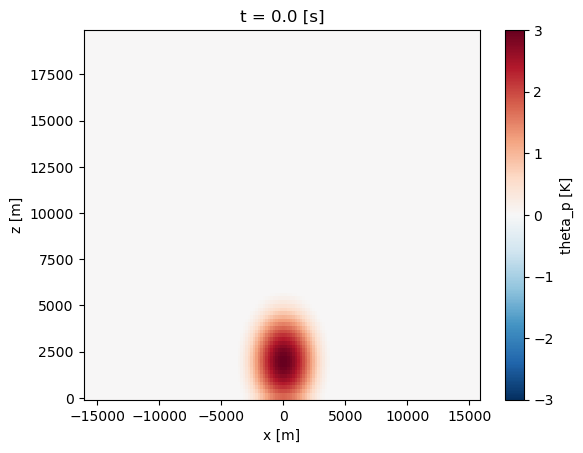

In [23]:
results[0]['theta_p'][0].plot.imshow(vmin=-3, vmax=3, cmap='RdBu_r')

#### Running the model forward in time

Now, we can actually start integrating in time. At the first timestep, we don't have the data to use leapfrog integration, so we need a special first timestep that does an forward-in-time approach (also known as Euler forward differencing):

In [24]:
# Integrate the model, saving after desired timestep counts
model.take_first_timestep()
results.append(model.current_state())

TODO: fix/adjust approach later

Now, the model (as written above) has been found to have a numerical instability that causes the model to "explode" within 30 seconds of simulated time. To showcase how such a model can go wrong, we save results every timestep, as follows:

In [ ]:
for _ in range(25000):
    model.integrate(1)
    results.append(model.current_state())

# Merge results
ds = xr.concat(results, 't')

In [21]:
mv = ModelVis(ds)
mv.panes

Column
    [0] Row
        [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
        [1] ParamFunction(function, _pane=HoloViews, defer_load=False)
        [2] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] Row
        [0] ParamFunction(function, _pane=HoloViews, defer_load=False)
        [1] ParamFunction(function, _pane=HoloViews, defer_load=False)
        [2] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [2] FloatSlider(end=np.float64(20.001), name='Time (s)', step=np.float64(0.001))

TODO: add holoviews visualization of "what's going wrong"



---

## Troubleshooting Model Instability

For numerical instability issues (when the model “explodes”), sensitivity testing is a key diagnostic approach. The idea is to identify the variables that may influence stability and then vary them one at a time while keeping all other factors constant. In this case, we present three example tests below:

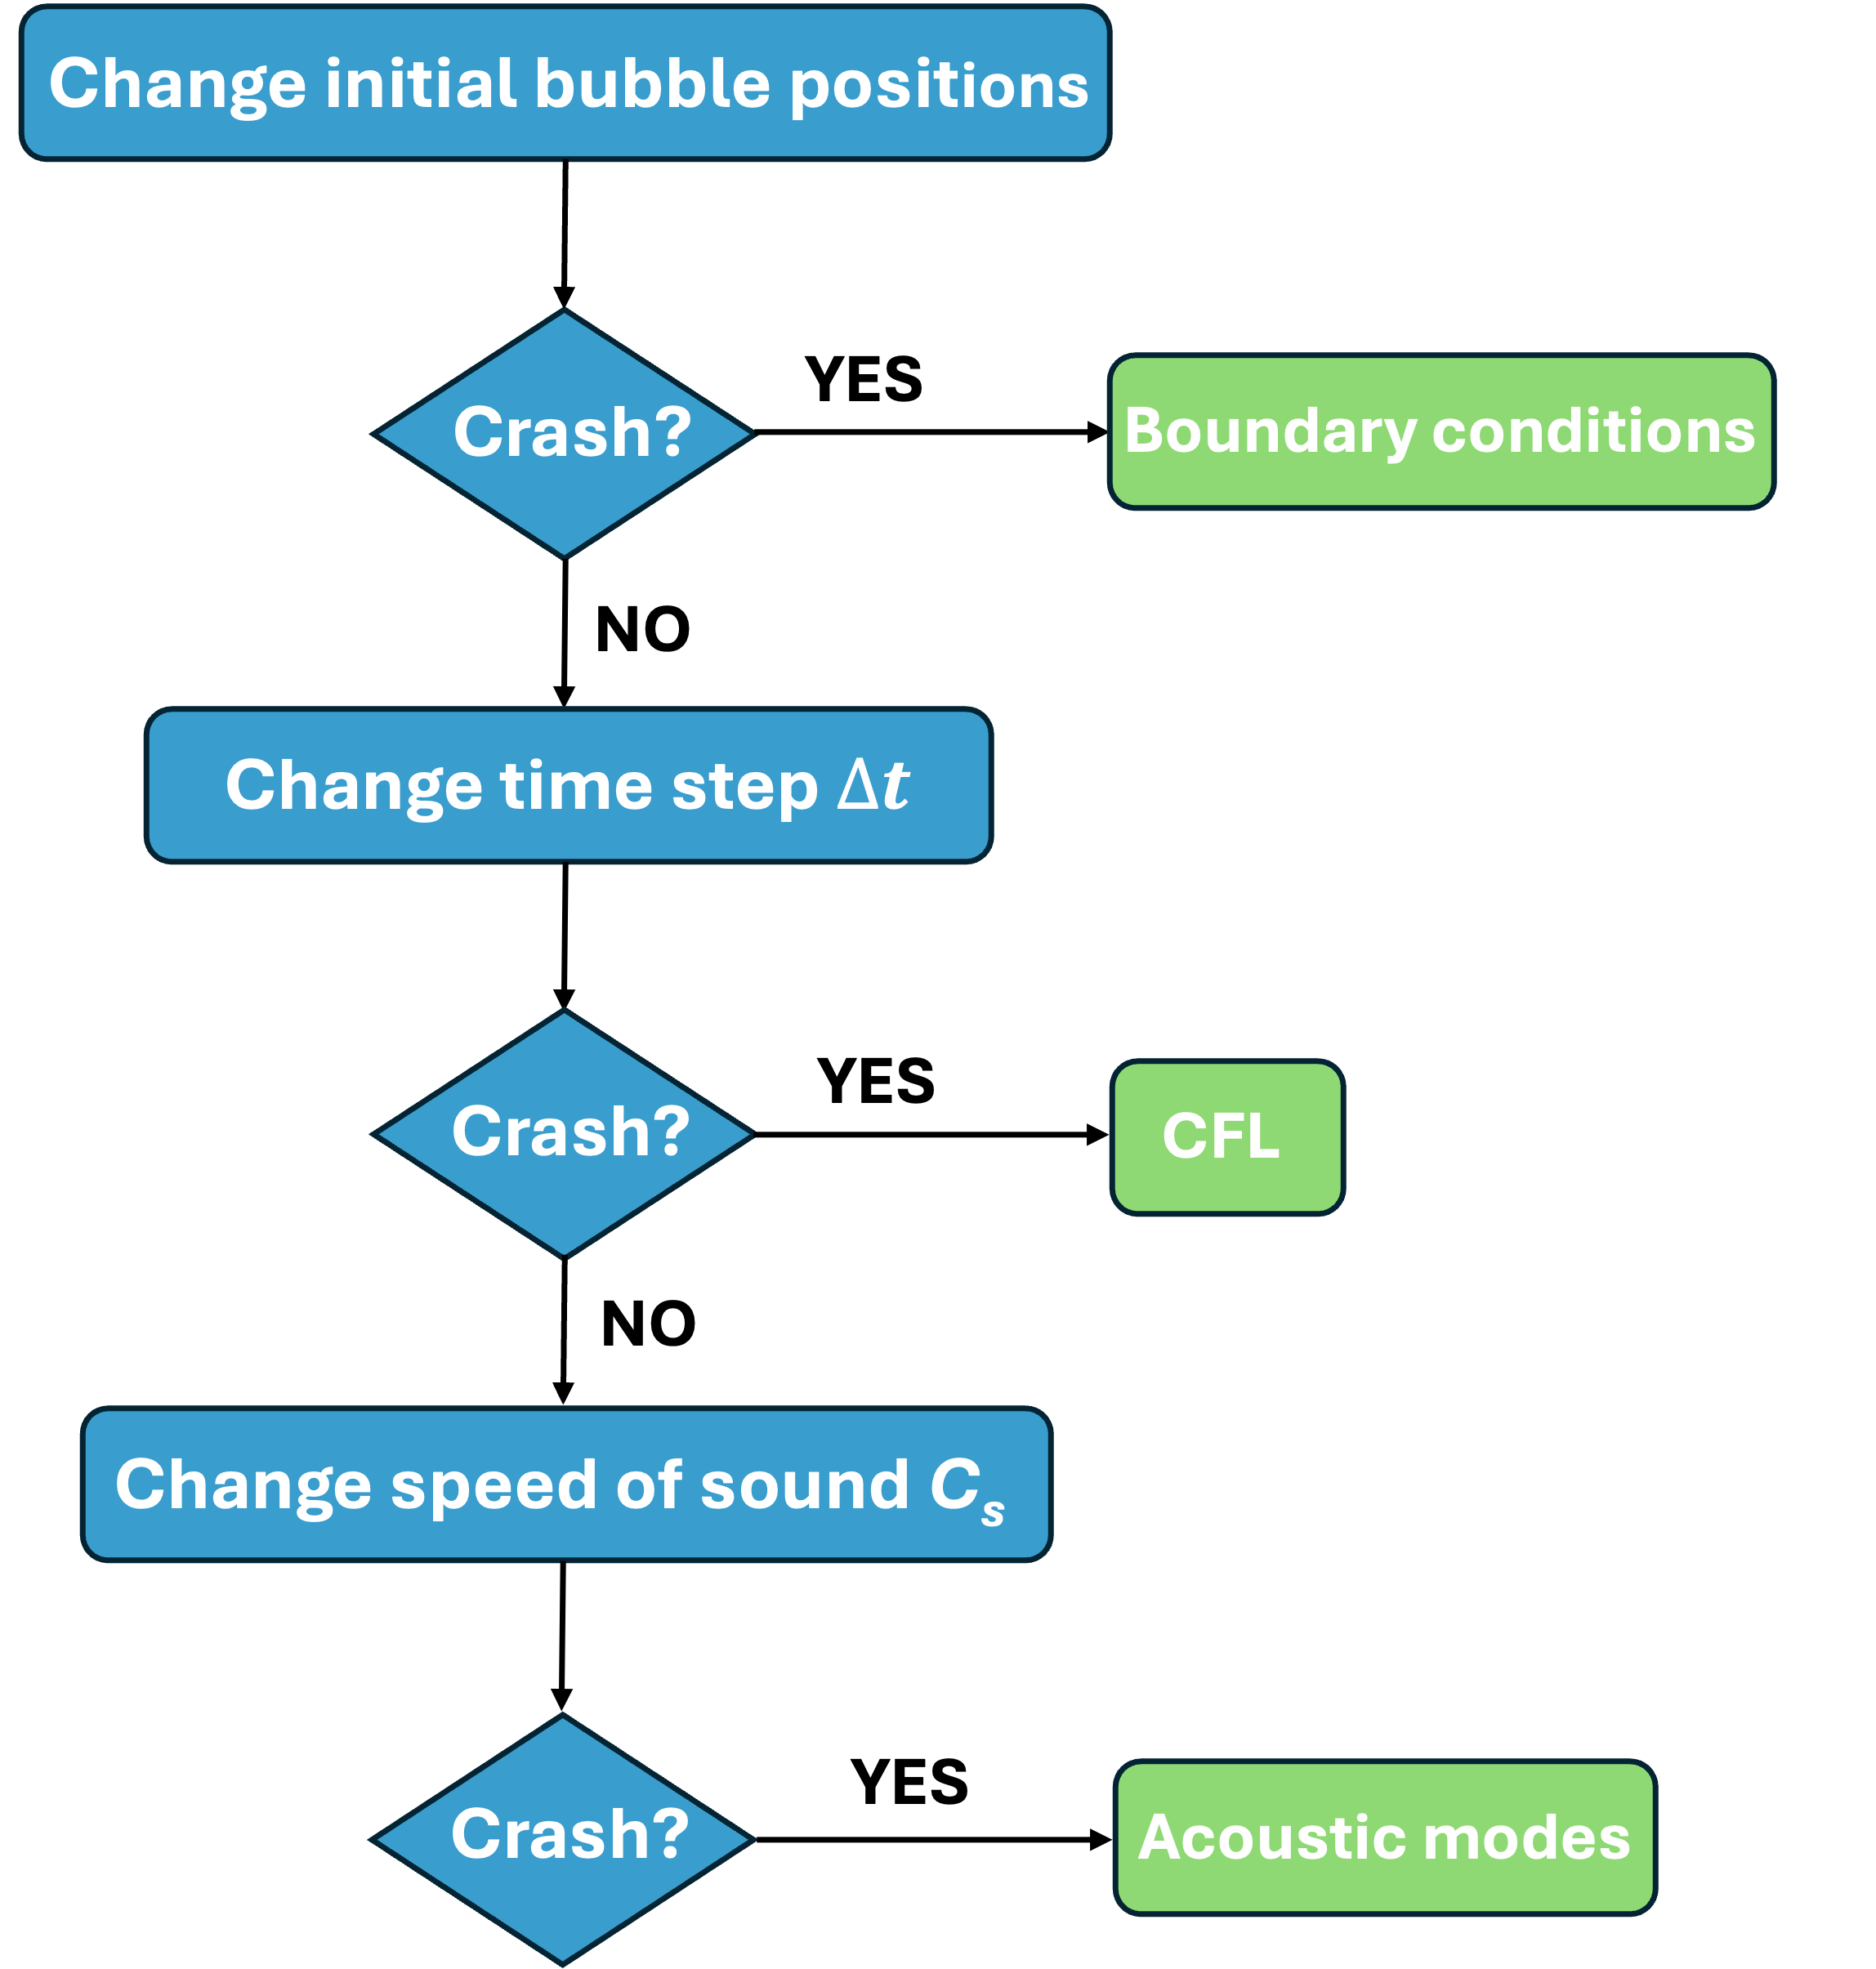

### Test 1: Change Initial Bubble Position

#### Purpose: 
Determine whether instability is caused by inappropriate boundary condition.
#### Procedure:
Place the initial thermal bubble in different positions (center, near top, near bottom, near lateral edges).
Keep all other model parameters fixed.
#### Diagnosis Logic:
If instability occurs only when the bubble is near a specific boundary (e.g., bottom), this points to boundary condition problems such as spurious reflections or incorrect implementation.


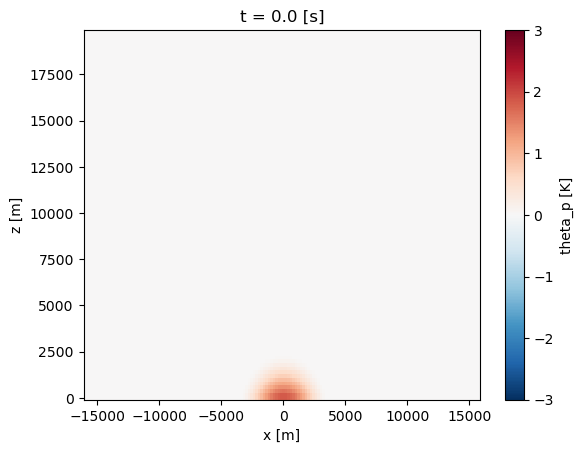

In [27]:
# Set up model
model = ModelDriver(
    nx=160, nz=100, dx=200., dz=200., dt=0.01, c_s_sqr=50.0**2,
    u_tendency=u_tendency, w_tendency=w_tendency, theta_p_tendency=theta_p_tendency, pi_tendency=pi_tendency
)
model.initialize_isentropic_base_state(300., 9.5e4)
# change initial bubble positions to the top
model.initialize_warm_bubble(3.0, 4.0e3, 4.0e3, 2.0e4)

# Start saving results
results = []
results.append(model.current_state())
results[0]['theta_p'][0].plot.imshow(vmin=-3, vmax=3, cmap='RdBu_r')

### Test 2: Change Time Step (Δt)
#### Purpose: 
Test the temporal stability of the time integration scheme and check CFL compliance.
#### Procedure:
Reduce Δt incrementally (e.g., 0.01 → 0.005 s).
Run simulations for each Δt without changing spatial resolution or physical parameters.
#### Diagnosis Logic:
If instability disappears or is delayed when Δt is reduced, the issue may be CFL condition violation or insufficient temporal resolution for fast modes (acoustic or gravity waves).
If there is no change, instability may not be driven by time step size.

In [ ]:
# Set up model and change dt to a different number
model = ModelDriver(
    nx=160, nz=100, dx=200., dz=200., dt=0.005, c_s_sqr=50.0**2,
    u_tendency=u_tendency, w_tendency=w_tendency, theta_p_tendency=theta_p_tendency, pi_tendency=pi_tendency
)
model.initialize_isentropic_base_state(300., 9.5e4)
model.initialize_warm_bubble(3.0, 4.0e3, 4.0e3, 2.0e3)

# Start saving results
results = []
results.append(model.current_state())

# Integrate the model, saving after desired timestep counts
model.take_first_timestep()
results.append(model.current_state())

for _ in range(25000):
    model.integrate(1)
    results.append(model.current_state())

# Merge results
ds = xr.concat(results, 't')

# visulize the results
mv = ModelVis(ds)
mv.panes

### Test 3: Change Speed of Sound (cs)
#### Purpose: 
Isolate the role of acoustic modes in driving instability.
#### Procedure:
Modify Cs in the model physics.
Lower values slow acoustic waves; higher values speed them up.
#### Diagnosis Logic:
If stability changes when csc_scs changes, acoustic wave behavior and their interactions with boundaries are important.
This also indirectly modifies the acoustic CFL condition, so link findings back to Test 2 results.

In [ ]:
# Set up model and change Cs to a different number
model = ModelDriver(
    nx=160, nz=100, dx=200., dz=200., dt=0.01, c_s_sqr=50.0,
    u_tendency=u_tendency, w_tendency=w_tendency, theta_p_tendency=theta_p_tendency, pi_tendency=pi_tendency
)
model.initialize_isentropic_base_state(300., 9.5e4)
model.initialize_warm_bubble(3.0, 4.0e3, 4.0e3, 2.0e3)

# Start saving results
results = []
results.append(model.current_state())

# Integrate the model, saving after desired timestep counts
model.take_first_timestep()
results.append(model.current_state())

for _ in range(25000):
    model.integrate(1)
    results.append(model.current_state())

# Merge results
ds = xr.concat(results, 't')

# visulize the results
mv = ModelVis(ds)
mv.panes

## Summary

The preceding cookbook provided a crash-course on the development of a 2-D Mesoscale Numerical Model, starting with the basic dynamical equations through the conversion to computer code and ultimately model integration. This pre-configured "test-case" is intended to be used for educational purposes only. Though note that all the assumptions/configurations used herein may not be applicable for other situations. Future notebooks are to be included, demonstrating how various configurations (i.e., equation simplifications, discritization schemes, boundary conditions, grid styles, and spatiotemporal resolutions) all influences the performance and accuracy of the resultant output. Additionally, we plan to include explicit walk-throughs regarding stability analyses, corrections, and filtering techniques. Check-in regularly for updates to this Cookbook.

### What's next?

TODO: reference later portions

<!--Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!-->

## Resources and references

TODO: add these

<!--
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!
-->